## Projeto 1

Este trabalho compara a eficiência e eficácia de múltiplos algoritmos de Aprendizado por Reforço (RL), sem eles MonteCarlo, Sarsa(Lambda) e Q_learning, em diferentes cenários e variando seus parâmetros quando necessário. O ambiente/problema que foi usado como teste são labirintos, onde os algoritmos precisam encontrar uma politica ótima para que o agente consiga chegar até o final do labirinto.

### Ambiente
Como dito anteriormente, os ambientes são labirintos. Eles são descritos por meio de arquivos .txt, onde são apontados as paredes, caminhos, estados terminais, formato e suas recompensas. Os arquivos têm essa cara:
```
4 4
. path -1
@ agent -1
$ goal 100
# wall -1000
######
#...$#
#@...#
######
```

Aqui é descrito um labirinto de tamanho 4x4, onde os caminhos são '.' e possuem recompensa de -1. Por sua o estado terminal, ou objetivo, é representado por '$' e possui recompensa de 100. Por fim, após a descrição dos simbolos, há a descrição do próprio formato do labirinto.

Diferentes formatos de labirintos foram adotados para o trabalho, sendo alguns bem aplos, outros com diversos caminhos, e outros extremamente estreitos. As recompensas também foram alteradas para avaliar seu impacto, já que a escolha de uma função de recompensa boa também faz parte do processo quando se trabalha com RL.

### Código
As primeiras células desse notebook contém o código usado para implementação e obtenção dos resultados. Porém para facilitar, foram geradas imagens com os resultados obtidos, e a análise foi feita em cima delas. O código fica a disposição para quem quiser rodar novamente, mudar valores, testar outras configurações de labirinto.

### Métricas
Para comparação dos algoritmos entre si, foram extraídas as recompensas médias e o tamanho do caminho percorrido a partir de um mesmo ponto do mapa. Com isso é possível analisar o quão eficiente foi o caminho encontrado pelo algoritmo, caso encontrado, e se ele conseguiu convergir. Há também a analise de desempenho e custo computacional, em média quantos episódios foram necessários para que o algoritmo converja? Quanto tempo de treinamento um algoritmo precisou para isso? Há também as analises individuais. Quantos hiperparametros são necessários para ajustar o algoritmo, e o quão dificil é encontrar um valor ótimo?  

Além disso, um mapa de calor gerado a partir da função valor será usado para ilustrar o quão bom é estar em cada estado, ou seja, em cada posição do labirinto.


In [28]:
import numpy as np
from itertools import product
import random
from threading import Thread
import time
from argparse import ArgumentParser
import matplotlib.pyplot as plt
import numpy as np
import time

In [4]:
class Renderer():
    def __init__(self, chief, content, title=None, dimensions=(800, 800)):
        self.chief = chief
        self.content = content
        self.contents = [content] # para trocar entre janelas
        self.iConteudoAtual = 0 # para marcar qual o atual dentre os varios
        self.title = title
        self.dimensions = dimensions
        self.running = True
        if not self.title:
            self.title = type(chief).__name__   # title é o nome da classe
        
        self.load_sprites()

    def add_content(self,content):
        self.contents.append(content)

    def load_sprites(self):
        self.sprites = dict()
        self.sprites["path"] = '⬛'
        self.sprites["wall"] = '🧱'
        self.sprites["goal"] = '⚽'
        self.sprites["agent"] = '👾' 
        self.sprites["right"] = '➡️'
        self.sprites["up"] = '⬆️'
        self.sprites["left"] = '⬅️' 
        self.sprites["down"] = '⬇️'


    def show(self):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.sprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.sprites.get(obj,'❌'),end='')
            print('')

    def create_heatmap(data, cmap='viridis', title='Heatmap'):
        """
        Create a heatmap from a list of lists of floats.

        Parameters:
        - data: List of lists of floats representing the heatmap data.
        - cmap: Colormap for the heatmap (default is 'viridis').
        - title: Title for the heatmap (default is 'Heatmap').
        """
        data = np.array(data, dtype=float)

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Display the heatmap using imshow
        im = ax.imshow(data, cmap=cmap)

        # Add a colorbar to the right of the heatmap
        cbar = ax.figure.colorbar(im, ax=ax)

        # Set the title
        ax.set_title(title)

        # Show the plot
        plt.show()

    def show_path(self, path):
        for i in range(len(self.content)):
            for j in range(len(self.content[0])):
                cell = self.content[i][j]
                if((i,j) in path.keys()):
                    cell = path[(i,j)]
                # se o content de cell estiver no dicionario de sprites
                if cell in self.sprites:
                    obj = cell
                else:
                    obj = self.chief.symbols[cell]
                print(self.sprites.get(obj,'❌'),end='')
            print('')


        


In [5]:
class Agent():
    actions = ['up', 'down', 'left', 'right']
    def __init__(self, x, y, environment, gamma = 0.9, display=True):
        self.environment = environment
        self.x = x
        self.y = y
        self.gamma = gamma
        self.display = display

    def action_idx(self, action: str):
        return self.actions.index(action)


    def startQ(self, shape, start_value = float("-inf")):
        """
        livroQ é uma lista de listas de dicionarios,
        ele armazena 
        
        """
        self.book_Q: list[list[dict]] = []
        for i in range(shape[0]):
            self.book_Q.append([])
            for _ in range(shape[1]):
                self.book_Q[i].append(dict())
                for action in self.actions:
                    self.book_Q[i][-1][action] = start_value

    def startV(self, shape):
        """
        livroV é uma lista de listas de dicionarios,
        ele armazena 
        
        """ 
        self.book_V: list[list] = []
        for i in range(shape[0]):
            self.book_V.append([])
            for _ in range(shape[1]):
                
                self.book_V[i].append(float("-inf"))
    
    def startPolicy(self, shape, randomPolicy):
        """
        A policy é uma matriz de caracteres que guarda a action principal
        a ser tomada ate o momento
        
        """
        self.policy: list[list[str]] = []
        for i in range(shape[0]):
            self.policy.append([])
            for j in range(shape[1]):
                if self.environment.symbols[self.environment.original_map[i][j]] == "wall":
                    self.policy[i].append("wall")
                    continue
                if randomPolicy:
                    self.policy[i].append(random.choice(self.actions))
                else:
                    self.policy[i].append(self.actions[0])
        if self.display:
            self.render = Renderer(self, self.policy, "Agente")

    def startReturns(self, shape):
        """
        returns é uma colecao de pares state action guardando um
        dicionario para armazenar o valor maximo de rewards obtidos,
        o numero de vezes que o par state action foi visitado e o ultimo
        episodio em que o par state action foi visitado
        """
        self.returns: list[list[dict]] = []
        for i in range(shape[0]):
            self.returns.append([])
            for j in range(shape[1]):
                self.returns[i].append(dict())
                for action in self.actions:
                    self.returns[i][j][action] = {"value": 0, "count": 0, "lastEpisode": 0}

    def setEnvironment(self, environment):
        self.environment = environment
    
    def setPos(self, position):
        self.x = position[1]
        self.y = position[0]

    def move(self, action):
        return self.environment.move(self, action)
    
    def get_action(self):
        return self.policy[self.y][self.x]


In [29]:
class LearningStrategy():
    def train(self, episodes):
        pass

    def setup(self, environment, agent):
        self.environment = environment
        self.agent = agent

class MonteCarlo(LearningStrategy):
    def __init__(self) -> None:
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []


    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)
    
    def train(self, episodes, randomPolicy = True, exploration_chance = 0):
        # Initialize
        shape = self.environment.get_size()
        self.agent.startPolicy(shape, randomPolicy)
        self.agent.startReturns(shape)
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))
        self.agent.startV(shape)

        for ep in range(episodes):
            start_time = time.time()
            if ep % (episodes//10) == 0:
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)
            # escolhe posicao aleatoria valida para o agente
            while True:
                state = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[state[0]][state[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            # escolhe uma action diferente da dita pela politica atual
            for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                action = random.choice(self.agent.actions)
                if action != self.agent.policy[state[0]][state[1]]:
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): 
                        break
            else:
                action = self.agent.policy[state[0]][state[1]]
            self.episode(state, action, max_steps= shape[1]*shape[0], exploration_chance = exploration_chance)
            g = 0
            for t in range(len(self.agent.recalls)-1, -1, -1): 
                memory = self.agent.recalls[t]  # memory = (state, action, reforco)
                g = self.agent.gamma*g + memory[2]
                # verifica se o par state action ja foi inserido em returns
                if self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] != ep:
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["lastEpisode"] = ep
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"] += g
                    self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"] += 1
                    media = self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["value"]/self.agent.returns[memory[0][0]][memory[0][1]][memory[1]]["count"]
                    self.Q[memory[0][0],memory[0][1],self.agent.action_idx(memory[1])] = media
                    self.agent.book_V[memory[0][0]][memory[0][1]] = media
                    self.agent.policy[memory[0][0]][memory[0][1]] = max(self.agent.actions, key = lambda action: self.get_Q(memory[0][0],memory[0][1],self.agent.action_idx(action)))    # recebe a action que maximiza o valor de Q
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)

    def episode(self, state, action, max_steps, exploration_chance=0):
        step_count = 0
        self.agent.recalls = []
        self.environment.setAgentPos(state[0], state[1])
        episode_R = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):  # enquanto nao estiver em um state terminal
            step_count +=1  # incrementa o numero de passos
            lastPos = (self.agent.y, self.agent.x)
            reward = self.environment.move(self.agent,action) # realiza a action e recebe a recompensa
            episode_R.append(reward)
            self.agent.recalls.append((lastPos, action, reward)) # guarda o passo
            if random.random() < exploration_chance:
                for _ in range(len(self.agent.actions)*2):    # limite maximo de tentativas
                    action = random.choice(self.agent.actions)
                    # se a action nao te leva para uma parede
                    if self.environment.util(state, action): break
            else:
                action = self.agent.get_action() # escolhe uma action de acordo com a politica
        self.episode_R.append(episode_R)
        self.episode_length.append(step_count)

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        state = starting_point
        self.environment.setAgentPos(state[0], state[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            action =  self.agent.policy[state[0]][state[1]]
            R = self.environment.move(self.agent, action)
            tuples.append((state,action,R))
            state = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples


class SARSA(LearningStrategy):

    def __init__(self, lam):
        super().__init__()
        self.lam = lam
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []

    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)
        

    def get_greedy_action(self,state):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
    
    def get_epsilon_greedy(self, exploration_chance, state):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.001):
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))

        E = dict()
        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if ep % (episodes//10) == 0: 
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)

            E = dict()         
            
            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            A = self.get_epsilon_greedy(ec,S)
            A_idx = self.agent.action_idx(A)

            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):

                R = self.environment.move(self.agent, A)
                episode_R.append(R)
                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_epsilon_greedy(ec, S_prime)
                A_prime_idx = self.agent.action_idx(A)
                
                pair = (S, A)
                E[pair] = E[pair] + 1 if pair in E.keys() else 1

                delta = R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx) - self.get_Q(S[0], S[1], A_idx)

                for (s, a) in E.keys():
                    a_idx = self.agent.action_idx(a)
                    self.Q[s[0],s[1], a_idx] += alpha * delta * E[(s,a)]
                    E[(s,a)] *= self.agent.gamma * self.lam
                
                S = S_prime
                A = A_prime
                step_count += 1
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action)))

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples
            



class LinearFunctionApproximation(LearningStrategy):
    ...

class QLearning(LearningStrategy):
    def __init__(self):
        super().__init__()
        self.episode_R = []
        self.episode_length = []
        self.Q = None
        self.W = np.random.rand(3)
        self.time = []

    def get_Q(self, x, y, action, linear_approximation = False):
        if not linear_approximation:
            return self.Q[x,y,action]
        
        terms = np.array([x,y,action])
        return np.dot(self.W, terms).astype(int)

    def get_greedy_action(self,state):
        return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
    
    def get_epsilon_greedy(self, exploration_chance, state):
        if random.random() < exploration_chance:
            return random.choice(self.agent.actions)
        else:
            return max(self.agent.actions, key = lambda action: self.get_Q(state[0], state[1], self.agent.action_idx(action)))
                
    def train(self, episodes, random_policy=True, exploration_chance=0.3, alpha=0.003):
        shape = self.environment.get_size()
        ec = exploration_chance
        num_states = shape[0]*shape[1]
        linear_decay = exploration_chance/episodes
        self.Q = np.zeros((shape[0],shape[1], len(self.agent.actions)))

        for ep in range(episodes):
            start_time = time.time()
            episode_R = []
            if ep % (episodes//10) == 0: 
                print(f"{ep=}")
                path = self.path_from((1,1))
                print('Tamanho do episódio:', len(path))
                print('Recompensa', sum([i[2] for i in path]))
                path_dict = {}
                for s,a,r in path:
                    path_dict[s] = a
                self.environment.render.show_path(path_dict)

            # escolhe posicao aleatoria valida para o agente
            while True:
                S = (random.randrange(0, shape[0]), random.randrange(0, shape[1]))
                if self.environment.original_map[S[0]][S[1]] in {self.environment.default_symbols["path"], self.environment.default_symbols["goal"]}:
                    break
            self.environment.setAgentPos(S[0], S[1])

            #A = random.choice(self.agent.actions)
            step_count = 0
            while (not self.environment.in_terminal_state()) and (step_count < num_states):
                A = self.get_epsilon_greedy(ec,S)
                A_idx = self.agent.action_idx(A)

                R = self.environment.move(self.agent, A)

                episode_R.append(R)

                S_prime = (self.agent.y, self.agent.x)
                A_prime = self.get_greedy_action(S_prime)
                A_prime_idx = self.agent.action_idx(A)


                self.Q[S[0], S[1], A_idx] += alpha*(R + self.agent.gamma * self.get_Q(S_prime[0], S_prime[1], A_prime_idx) - self.get_Q(S[0], S[1], A_idx))

                
                S = S_prime
                step_count += 1
                
            self.episode_R.append(episode_R)
            self.episode_length.append(step_count)
            ec-=linear_decay
            end_time = time.time()
            time_difference_seconds = end_time - start_time
            self.time.append(time_difference_seconds)
            

        self.agent.startPolicy(shape, random_policy)
        self.agent.startV(shape)
        for i in range(shape[0]):
            for j in range(shape[1]):
                if(self.environment.original_map[i][j] == '#'): self.agent.policy[i][j] = "wall"
                else: 
                    self.agent.policy[i][j] = max(self.agent.actions, key = lambda action: self.get_Q(i,j, self.agent.action_idx(action)))
                    self.agent.book_V[i][j] = max(self.Q[i,j,:])

    def path_from(self, starting_point):
        shape = self.environment.get_size()
        max_steps = shape[0] * shape[1]
        step_count = 0
        S = starting_point
        self.environment.setAgentPos(S[0], S[1])
        tuples = []
        while (not self.environment.in_terminal_state()) and (step_count < max_steps):
            A = self.get_greedy_action(S)
            R = self.environment.move(self.agent, A)
            tuples.append((S,A,R))
            S = (self.agent.y, self.agent.x)
            step_count+=1
        return tuples

In [7]:
class Environment:
    default_symbols = {"agent": '@', "wall": '#', "path": '.', "goal":'$'}
    def __init__(self, path, display=True, starting_point = (1,1)) -> None:
        self.display = display
        self.original_map = self.load_map(path)
        self.map = self.copy_map(self.original_map)
        self.wait_time = 0
        self.starting_point = starting_point

        if self.display:
            self.render = Renderer(self, self.map, "Ambiente")
            print(self.render)

    def copy_map(self, map):
        map_copy = []
        for row in map:
            map_copy.append([])
            for cell in row:
                map_copy[-1].append(cell)
        return map_copy

    def getAgent(self) -> Agent:
        return self.agent

    def in_terminal_state(self):
        return self.original_map[self.agent.y][self.agent.x] == self.default_symbols["goal"]


    def load_map(self, path):
        """
        Dado o caminho path, le um file txt e retorna uma matriz
        O txt consiste de uma row contendo o numero n (número de
        rows do grid) e m (número de caracteres diferentes no grid),
        seguido de m rows explicando o que sao os caracteres no 
        file e por fim n rows contendo o grid que sao caracteres
        """

        grid = []
        self.symbols = dict()
        self.rewards = {"agent": 0, "wall": 0, "path": 0, "goal":0}
        with open(path, 'r') as file:
            m, n = map(int, file.readline().split())
            for _ in range(m):
                row = file.readline().split()
                self.symbols[row[0]] = row[1]
                self.rewards[row[1]] = int(row[2])
            for i in range(n):
                row = file.readline()
                grid.append([])
                for j in range(len(row)):
                    char = row[j]
                    if char == '\n':
                        continue
                    if self.symbols[char] == 'agent':
                        self.agent = Agent(x=j, y=i, environment=self, display=self.display)
                        char = self.default_symbols["path"]
                    grid[-1].append(self.default_symbols[self.symbols[char]])
        return grid
    
    def move(self, agent, action):
        """
        Dada uma action, move o agente no map
        a action pode ser "up", "down", "left" ou "right"
        """
        #time.sleep(self.wait_time)
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (agent.y+direction[action][0], agent.x+direction[action][1])
        if self.map[final_pos[0]][final_pos[1]] != self.default_symbols["wall"]:
            # seta a posicao atual como caminho
            self.map[agent.y][agent.x] = self.original_map[agent.y][agent.x]
            
            # seta a posicao final como o agente
            self.map[final_pos[0]][final_pos[1]] = self.default_symbols["agent"]
            
            # atualiza a posicao do agente
            agent.setPos(final_pos)
        # retorna o reforco da posicao final 
        return self.rewards[self.symbols[self.original_map[agent.y][agent.x]]]

    def util(self, pos, action):
        """
        Dada uma posicao e uma action, retorna o que tem na posicao destino
        """
        direction = {"up": (-1, 0), "down": (1, 0), "left": (0, -1), "right": (0, 1)}
        final_pos = (pos[0]+direction[action][0], pos[1]+direction[action][1])
        return self.symbols[self.map[final_pos[0]][final_pos[1]]] != "wall"

    def get_size(self):
        return len(self.map), len(self.map[0])
    
    def setAgentPos(self, i, j):
        self.map[self.agent.y][self.agent.x] = self.original_map[self.agent.y][self.agent.x]
        self.agent.setPos((i, j))
        self.map[i][j] = self.default_symbols["agent"]

In [32]:
learning_strategy = MonteCarlo()
environment = Environment('./salas/sala2.txt', True)
agent = environment.getAgent()
learning_strategy.setup(environment, agent)

learning_strategy.train(10000, exploration_chance=0.5)
agent.render.show()
print("Done")
print(sum(learning_strategy.time))

ep=0
Tamanho do episódio: 24
Recompensa -24
🧱🧱🧱🧱🧱🧱
🧱⬇️⬛⬛⚽🧱
🧱➡️⬇️⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=1000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=2000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=3000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=4000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=5000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=6000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=7000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=8000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
ep=9000
Tamanho do episódio: 3
Recompensa 98
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️👾🧱
🧱⬛⬛⬛⬛🧱
🧱🧱🧱🧱🧱🧱
🧱🧱🧱🧱🧱🧱
🧱➡️➡️➡️➡️🧱
🧱➡️➡️➡️⬆️🧱
🧱🧱🧱🧱🧱🧱
Done
0.20281314849853516


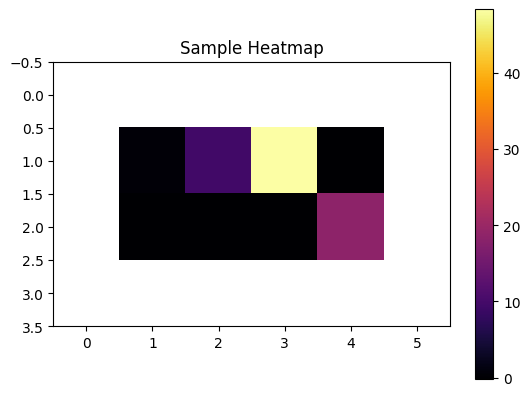

In [12]:
Renderer.create_heatmap(learning_strategy.agent.book_V, cmap='inferno', title='Sample Heatmap')